In this notebook, I fit a mixed linear regression model to predict reaction times based on two fixed effects: time (time) and probability (pin).

Also, I will include a random effect for subject (subject)


The models are all fitted with the R lme4 package, that is imported to python using pymer4.
I have tested before if the results are comparable between this package and the python package statsmodels, and they are.
Also, all tested models returned the exact same results when run directly in R.

In [1]:
# Import packages and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.0.3'

import pymer4
from pymer4.models import Lmer, Lm


# load data file
data = pd.read_csv('../2_cleaned/long_data.csv')
# reduce the data file to the most important variables
df = data.loc[:,['subject', 'rea_time', 'time', 'pin_t']]

df.groupby('subject').describe()

rea_time                                                          \
           count        mean        std        min        25%        50%   
subject                                                                    
AD        7776.0  523.355234  84.928841  308.62492  458.05462  516.42816   
AE        6120.0  538.388073  72.485947  349.76576  483.16480  524.96942   
AF        4290.0  464.960825  99.478507  258.13300  391.17708  450.39860   
AG        8196.0  628.699013  57.019423  433.15096  591.05544  625.07846   

                                 time              ...                 pin_t  \
               75%        max   count        mean  ...    75%    max   count   
subject                                            ...                         
AD       582.96346  758.10784  7776.0  416.486754  ...  666.0  834.0  7776.0   
AE       583.10857  774.63068  6120.0  416.489379  ...  666.0  839.0  6120.0   
AF       532.67344  766.53672  4290.0  416.513753  ...  666.0  834.0  4290.0   
AG       674.36600  774.66284  8196.0  416.515861  ...  666.0  842.0  8196.0   

                                                                
             mean       std  min       25%       50%  75%  max  
subject                                                         
AD       0.750814  0.330695  0.0  0.571581  0.933187  1.0  1.0  
AE       0.850552  0.240773  0.0  0.776947  1.000000  1.0  1.0  
AF       0.801466  0.294984  0.0  0.686984  0.989326  1.0  1.0  
AG       0.741859  0.333676  0.0  0.551209  0.919044  1.0  1.0  

[4 rows x 24 columns]

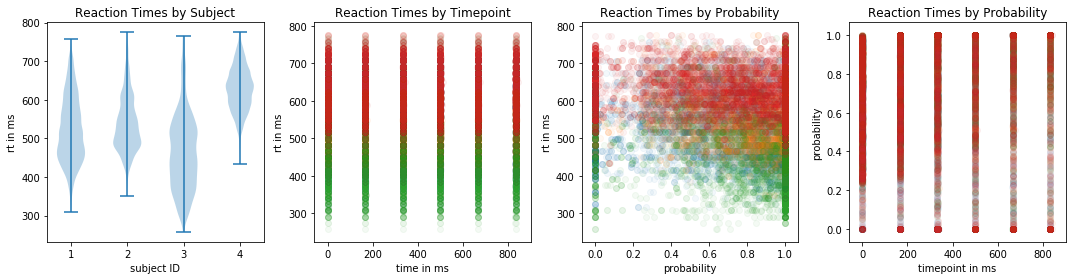

In [2]:
# In the first step, let's look at the variables we are trying to map
fig_overview, axs1 = plt.subplots(1,4, figsize = (15,4))

subject_rt = [df.rea_time[df.subject == s].values for s in np.unique(df.subject)]

axs1[0].violinplot(subject_rt)
axs1[0].set_ylabel('rt in ms')
axs1[0].set_xlabel('subject ID')
axs1[0].set_title('Reaction Times by Subject')

subject_time = [df.time[df.subject == s].values for s in np.unique(df.subject)]

for t, rt in zip(subject_time, subject_rt):
    axs1[1].scatter(t, rt, alpha = 0.05)
    axs1[1].set_ylabel('rt in ms')
    axs1[1].set_xlabel('time in ms')
    axs1[1].set_title('Reaction Times by Timepoint')

subject_pin = [df.pin_t[df.subject == s].values for s in np.unique(df.subject)]

for pin, rt in zip(subject_pin, subject_rt):
    axs1[2].scatter(pin, rt, alpha = 0.05)
    axs1[2].set_ylabel('rt in ms')
    axs1[2].set_xlabel('probability')
    axs1[2].set_title('Reaction Times by Probability')
    
for t, pin in zip(subject_time, subject_pin):
    axs1[3].scatter(t, pin, alpha = 0.05)
    axs1[3].set_ylabel('probability')
    axs1[3].set_xlabel('timepoint in ms')
    axs1[3].set_title('Reaction Times by Probability')
    
plt.tight_layout()

### Verbal Summary:
Subject vary in terms of reaction times.

The distribution of reaction times over time points is even. We would expect this even distribution, because every reaction time is associated with 6 time points (6 elements were shown in each trial, and one response was generated in each trial).

The probability shows that there are fewer data points with probability values below 0.5. However, there are many data points associated with probability values 0 and 1.

Finally, we see that probability values other than 0 and 1 occur less often in late time points. This results in more 0/1 probability values in late time points.

In [3]:
# We center all data point here, such that the mean value will be "0"

for s in np.unique(df.subject):
    
    df.loc[df.subject == s, 'time'] = df.loc[df.subject == s, 'time'] - np.mean(df.loc[df.subject == s, 'time'])
    df.loc[df.subject == s, 'pin_t'] = df.loc[df.subject == s, 'pin_t'] - np.mean(df.loc[df.subject == s, 'pin_t'])
    

In [4]:
# Let's explore the effects of each of the predicting variables individually

m_sub = Lm('rea_time ~ subject', data = df, family = 'gaussian')
m_sub_f = m_sub.fit()

m_sub_f

Formula: rea_time~subject

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 26382	 R^2: 0.359	 R^2_adj: 0.359

Log-likelihood: -152108.353 	 AIC: 304224.706	 BIC: 304257.428

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,523.355,521.639,525.072,0.876,26378,597.593,0.0,***
subject[T.AE],15.033,12.446,17.619,1.320,26378,11.392,0.0,***
subject[T.AF],-58.394,-61.273,-55.516,1.469,26378,-39.758,0.0,***
subject[T.AG],105.344,102.947,107.740,1.223,26378,86.167,0.0,***


### Verbal summary subjects:
Each subject introduces a significant intercept

In [5]:
# fit the model for time

m_time = Lm('rea_time ~ time', data = df, family = 'gaussian')
m_time_f = m_time.fit()

m_time_f

Formula: rea_time~time

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 26382	 R^2: 0.000	 R^2_adj: -0.000

Log-likelihood: -157975.994 	 AIC: 315955.987	 BIC: 315972.348

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,550.074,548.910,551.238,0.594,26380,926.255,0.0,***
time,-0.000,-0.004,0.004,0.002,26380,-0.000,1.0,


### Verbal summary time 
Time has no effect on the reaction time

In [6]:
# fit the model for probability

m_prob = Lm('rea_time ~ pin_t', data = df, family = 'gaussian')
m_prob_f = m_prob.fit()

m_prob_f

Formula: rea_time~pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 26382	 R^2: 0.008	 R^2_adj: 0.007

Log-likelihood: -157876.213 	 AIC: 315756.427	 BIC: 315772.788

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,550.074,548.914,551.233,0.592,26380,929.765,0.0,***
pin_t,-27.251,-31.026,-23.477,1.926,26380,-14.153,0.0,***


### Verbal summary probability

There is a negative relationship between probability and reaction time: 
When the probability increases by one unit, the average reaction time decreases by ~40 ms.

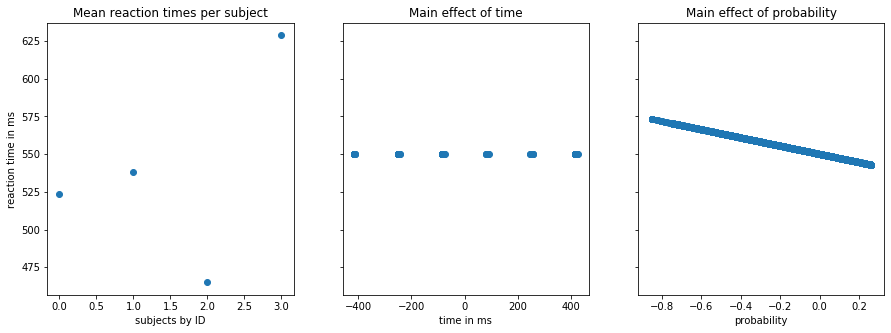

In [7]:
# Let's plot the effects of all 3 models
fig_single_main, axs2 = plt.subplots(1,3, figsize = (15,5), sharey=True)


# subjects
# intercept per subject:
sub_ic = [0]
sub_ic.append(m_sub_f.Estimate[1])
sub_ic.append(m_sub_f.Estimate[2])
sub_ic.append(m_sub_f.Estimate[3])

subs = [0,1,2,3]

axs2[0].scatter(subs, sub_ic+m_sub_f.Estimate[0])
axs2[0].set_title('Mean reaction times per subject')
axs2[0].set_ylabel('reaction time in ms')
axs2[0].set_xlabel('subjects by ID')

# time
axs2[1].scatter(df.time, df.time*m_time_f.Estimate['time']+m_time_f.Estimate[0])
axs2[1].set_title('Main effect of time')
axs2[1].set_xlabel('time in ms')

# probability
axs2[2].scatter(df.pin_t, df.pin_t*m_prob_f.Estimate['pin_t']+m_prob_f.Estimate[0])
axs2[2].set_title('Main effect of probability')
axs2[2].set_xlabel('probability');

### Verbal summary plots:

All plots appear to have the same mean reaction time values, which is good. 

### Nested Models - subject as random factor

Since we are not interested in between-subject variability, but in the variability of reaction time with the two factors time and probability, we can include subject as a random effect. For this, we will use a mixed linear regression.

In [8]:
# mixed linear regression for time

mmod_time = Lmer('rea_time ~ time + (1|subject)', data = df, family = 'gaussian')
mmod_time_f = mmod_time.fit()

mmod_time_f

Formula: rea_time~time+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -152127.891 	 AIC: 304255.781

Random effects:

                 Name       Var     Std
subject   (Intercept)  4589.914  67.749
Residual               5964.227  77.228

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.853,472.454,605.253,33.878,3.0,15.906,0.001,***
time,-0.000,-0.003,0.003,0.002,26377.0,-0.000,1.000,


### Verbal summary mixed effects model time

Still, there is no main effect of time

In [9]:
# mixed linear regression for probability

mmod_prob = Lmer('rea_time ~ pin_t + (1|subject)', data = df, family = 'gaussian')
mmod_prob_f = mmod_prob.fit()

mmod_prob_f

Formula: rea_time~pin_t+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151965.079 	 AIC: 303930.158

Random effects:

                 Name       Var     Std
subject   (Intercept)  4589.928  67.749
Residual               5894.104  76.773

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.853,472.454,605.253,33.878,3.0,15.906,0.001,***
pin_t,-27.251,-30.267,-24.236,1.538,26377.0,-17.715,0.000,***


In [10]:
mmod_prob.fixef

,(Intercept),pin_t
0,523.357793,-27.251405
1,538.388171,-27.251405
2,464.982937,-27.251405
3,628.684938,-27.251405


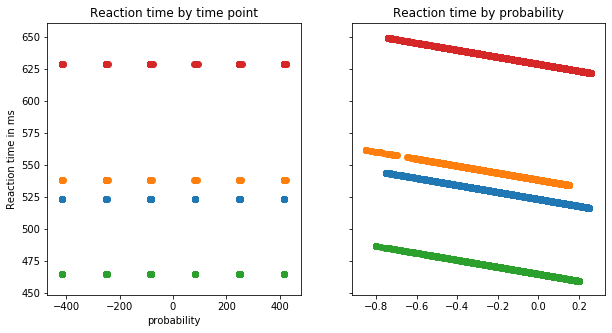

In [11]:
# Print the two mixed effect models

fig_mixed_main_effect, axs3 = plt.subplots(1,2, figsize = (10,5), sharey = True)

for pid, p in enumerate(np.unique(df.subject)):
    pdat = df[df.subject == p]
    
    rt_time_est = mmod_time.fixef['(Intercept)'][pid] + pdat.time.values*mmod_time_f.Estimate['time']
    rt_pin_est = mmod_prob.fixef['(Intercept)'][pid] + pdat.pin_t.values*mmod_prob_f.Estimate['pin_t']
    
    axs3[0].scatter(pdat.time, rt_time_est)
    axs3[1].scatter(pdat.pin_t, rt_pin_est)
    
axs3[0].set_title('Reaction time by time point')
axs3[1].set_title('Reaction time by probability')

axs3[0].set_ylabel('Reaction time in ms')
axs3[0].set_xlabel('time in ms')
axs3[0].set_xlabel('probability');

### Verbal summary

Allowing for random effects introduced different offsets. But we also want to allow different slopes per participant

In [12]:
# mixed linear regression for time with variation in slope

mmod_time_s = Lmer('rea_time ~ time + (1+time|subject)', data = df, family = 'gaussian')
mmod_time_s_f = mmod_time_s.fit()

mmod_time_s_f

boundary (singular) fit: see ?isSingular 

Formula: rea_time~time+(1+time|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -152128.069 	 AIC: 304256.137

Random effects:

                 Name       Var     Std
subject   (Intercept)  7749.950  88.034
subject          time     0.000   0.000
Residual               5963.952  77.227

                 IV1   IV2  Corr
subject  (Intercept)  time   1.0

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.852,452.575,625.129,44.020,1.161,12.241,0.036,*
time,-0.000,-0.003,0.003,0.002,180.695,-0.017,0.986,


In [13]:
# mixed linear regression for time with variation in slope

mmod_prob_s = Lmer('rea_time ~ pin_t + (1+pin_t|subject)', data = df, family = 'gaussian')
mmod_prob_s_f = mmod_prob_s.fit()

mmod_prob_s_f

Model failed to converge with max|grad| = 0.00310314 (tol = 0.002, component 1) 

Formula: rea_time~pin_t+(1+pin_t|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151961.459 	 AIC: 303922.917

Random effects:

                 Name       Var     Std
subject   (Intercept)  4598.325  67.811
subject         pin_t    56.933   7.545
Residual               5891.252  76.754

                 IV1    IV2   Corr
subject  (Intercept)  pin_t  0.111

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.853,472.393,605.314,33.909,2.992,15.891,0.001,***
pin_t,-28.767,-36.851,-20.683,4.124,2.664,-6.975,0.009,**


### Verbal summary

The overall interpretation has not changed much, but now we have introduced different slopes per participant

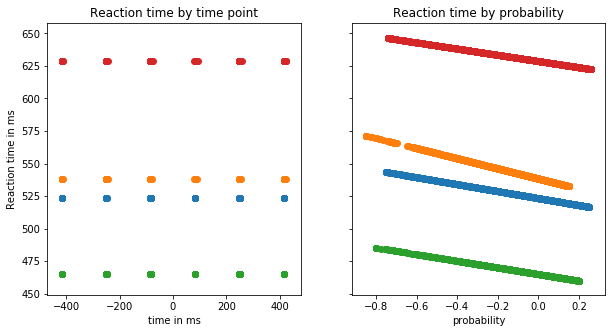

In [14]:
# Print the two mixed effect models with free slopes

fig_mixed_main_effect_slopes, axs4 = plt.subplots(1,2, figsize = (10,5), sharey = True)

for pid, p in enumerate(np.unique(df.subject)):
    pdat = df[df.subject == p]
    
    rt_time_est = mmod_time_s.fixef['(Intercept)'][pid] + pdat.time.values*mmod_time_s.fixef['time'][pid]
    rt_pin_est = mmod_prob_s.fixef['(Intercept)'][pid] + pdat.pin_t.values*mmod_prob_s.fixef['pin_t'][pid]
    
    axs4[0].scatter(pdat.time, rt_time_est)
    axs4[1].scatter(pdat.pin_t, rt_pin_est)
    
axs4[0].set_title('Reaction time by time point')
axs4[1].set_title('Reaction time by probability')

axs4[0].set_ylabel('Reaction time in ms')
axs4[0].set_xlabel('time in ms')
axs4[1].set_xlabel('probability');

In [33]:
mmod_time_s_f

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.852,452.575,625.129,44.020,1.161,12.241,0.036,*
time,-0.000,-0.003,0.003,0.002,180.695,-0.017,0.986,


In [30]:
mmod_time_s.ranef

,(Intercept),time
0,-15.495614,-0.000040
1,-0.464256,-0.000001
2,-73.878269,-0.000193
3,89.838140,0.000234


In [32]:
mmod_time_s.fixef

,(Intercept),time
0,523.356781,-0.000070
1,538.388139,-0.000030
2,464.974126,-0.000222
3,628.690535,0.000205


In [46]:
# mixed linear regression for time with variation in slope

clarasdream = Lmer('rea_time ~ pin_t + pin_t:time + (1 + pin_t + pin_t:time|subject)', data = df, family = 'gaussian')
clarasdream_f = clarasdream.fit()

clarasdream_f

boundary (singular) fit: see ?isSingular 

Formula: rea_time~pin_t+pin_t:time+(1+pin_t+pin_t:time|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151854.218 	 AIC: 303708.436

Random effects:

                 Name        Var      Std
subject   (Intercept)  11746.752  108.382
subject         pin_t     14.800    3.847
subject    pin_t:time      0.006    0.080
Residual                5842.027   76.433

                 IV1         IV2   Corr
subject  (Intercept)       pin_t  0.946
subject  (Intercept)  pin_t:time -0.990
subject        pin_t  pin_t:time -0.982

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.726,431.509,643.943,54.193,30042.900,9.922,0.000,***
pin_t,-31.657,-36.525,-26.789,2.484,3.212,-12.747,0.001,***
pin_t:time,0.086,0.007,0.165,0.041,17.825,2.121,0.048,*


In [37]:
# Next, we want to have time and probability in one model

mmod_two_main = Lmer('rea_time ~ pin_t + time + (1+pin_t+time|subject)', data = df, family = 'gaussian')
mmod_two_main_f = mmod_two_main.fit()

mmod_two_main_f

boundary (singular) fit: see ?isSingular 

Formula: rea_time~pin_t+time+(1+pin_t+time|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151963.901 	 AIC: 303927.802

Random effects:

                 Name       Var     Std
subject   (Intercept)  9070.859  95.241
subject         pin_t   691.809  26.302
subject          time     0.000   0.006
Residual               5888.116  76.734

                 IV1    IV2   Corr
subject  (Intercept)  pin_t  0.014
subject  (Intercept)   time  0.035
subject        pin_t   time -0.999

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.852,445.513,632.192,47.623,0.769,11.315,0.096,.
pin_t,-30.016,-56.010,-4.021,13.263,7848.422,-2.263,0.024,*
time,0.005,-0.001,0.012,0.003,1.079,1.511,0.359,


### Verbal summary model with two main effects and random stuff for subjects
The significance of probability was slighlty decreased, the probability on time was slightly increased
Otherwise, the interpretation is rather stable.
Let's plot the predctions

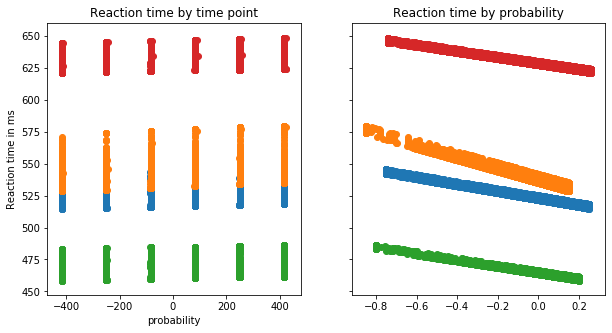

In [38]:
fig_main_eff_model, axs5 = plt.subplots(1,2, figsize = (10,5), sharey = True)

for pid, p in enumerate(np.unique(df.subject)):
    pdat = df[df.subject == p]
    
    rt_est = mmod_two_main.fixef['(Intercept)'][pid] + pdat.time.values*mmod_two_main.fixef['time'][pid] + pdat.pin_t.values*mmod_two_main.fixef['pin_t'][pid]
    
    axs5[0].scatter(pdat.time, rt_est)
    axs5[1].scatter(pdat.pin_t, rt_est)

axs5[0].set_title('Reaction time by time point')
axs5[1].set_title('Reaction time by probability')

axs5[0].set_ylabel('Reaction time in ms')
axs5[0].set_xlabel('time in ms')
axs5[0].set_xlabel('probability');
    

### Verbal summary of the 2 main effect model

Including more than one main effect has increased the "variability" in these two plots. We can see here, that more of the variability is explained by the probability, since the values around p_in don't differ by a lot. But the fact that they do differ at all is interesting. The slope introduced by time is not zero.

In [39]:
### Finally, we fit the full model with interactions

mmod_full = Lmer('rea_time ~ pin_t * time + (1+pin_t*time|subject)', data = df, family = 'gaussian')
mmod_full_f = mmod_full.fit()

mmod_full_f

boundary (singular) fit: see ?isSingular 

Formula: rea_time~pin_t*time+(1+pin_t*time|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151872.748 	 AIC: 303745.496

Random effects:

                 Name        Var      Std
subject   (Intercept)  11208.779  105.872
subject         pin_t   2372.853   48.712
subject          time      0.000    0.022
subject    pin_t:time    865.209   29.414
Residual                5834.536   76.384

                 IV1         IV2   Corr
subject  (Intercept)       pin_t  0.225
subject  (Intercept)        time -0.221
subject  (Intercept)  pin_t:time -0.000
subject        pin_t        time -1.000
subject        pin_t  pin_t:time  0.001
subject         time  pin_t:time -0.001

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.666,433.910,641.423,52.938,0.353,10.157,0.299,
pin_t,-34.296,-82.154,13.563,24.418,20.107,-1.405,0.175,
time,0.008,-0.014,0.029,0.011,1.350,0.703,0.583,
pin_t:time,0.088,-28.738,28.913,14.707,2354.902,0.006,0.995,


In [43]:
mmod_full.fixef

,(Intercept),pin_t:time
0,522.467881,0.070177
1,536.515103,0.105859
2,464.055800,0.092858
3,628.779858,-0.008482


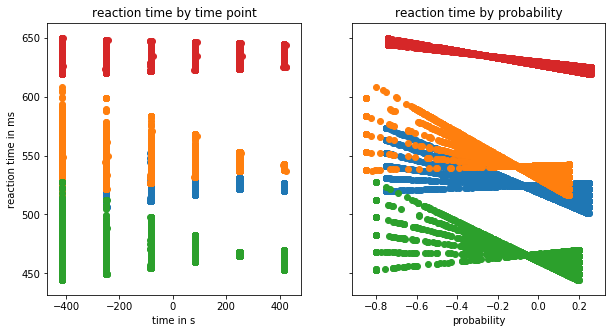

In [41]:
fig_full_model, axs6 = plt.subplots(1,2, figsize = (10,5), sharey = True)

for pid, p in enumerate(np.unique(df.subject)):
    pdat = df[df.subject == p]
    
    rt_est = mmod_full.fixef['(Intercept)'][pid] + pdat.time.values*mmod_full.fixef['time'][pid] + pdat.pin_t.values*mmod_full.fixef['pin_t'][pid]+pdat.pin_t.values*pdat.time.values*mmod_full.fixef['pin_t:time'][pid]
    
    axs6[0].scatter(pdat.time, rt_est)
    axs6[1].scatter(pdat.pin_t, rt_est)

axs6[0].set_title('reaction time by time point')
axs6[0].set_ylabel('reaction time in ms')
axs6[0].set_xlabel('time in s')
axs6[1].set_title('reaction time by probability')
axs6[1].set_xlabel('probability');



### Verbal summary full model
Here, none of the factors is significant. But also, do to the sheer number of parameters introduced, we might distribute the effect over many different parameters. So from here, the next step would be to reduce the number of parameters one by one till only significant parameters are left.

### EXPLORATION
It seems to matter a great deal which random effects I include. 
I want to explore that. So below, I will fit 3 additional models for the random effects.

In [20]:
# A model with only one intercept per subject

mmod_full_ic = Lmer('rea_time ~ pin_t * time + (1|subject)', data = df, family = 'gaussian')
mmod_full_ic_f = mmod_full_ic.fit()

mmod_full_ic_f

Formula: rea_time~pin_t*time+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151881.109 	 AIC: 303762.219

Random effects:

                 Name       Var     Std
subject   (Intercept)  4587.889  67.734
Residual               5852.816  76.504

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.879,471.494,604.264,33.871,3.000,15.880,0.001,***
pin_t,-32.481,-35.593,-29.369,1.588,26375.000,-20.459,0.000,***
time,0.007,0.004,0.010,0.002,26375.000,4.047,0.000,***
pin_t:time,0.075,0.064,0.086,0.006,26375.011,13.452,0.000,***


In [21]:
mmod_full_ic.fixef

,(Intercept),pin_t,time,pin_t:time
0,522.398010,-32.480904,0.00681,0.075357
1,537.073181,-32.480904,0.00681,0.075357
2,464.205786,-32.480904,0.00681,0.075357
3,627.838893,-32.480904,0.00681,0.075357


In [44]:
# A model with free intercepts for each main factor but no fixed intercepts for the interaction

mmod_full_twoic = Lmer('rea_time ~ pin_t * time + (1+pin_t+time|subject)', data = df, family = 'gaussian')
mmod_full_twoic_f = mmod_full_twoic.fit()

mmod_full_twoic_f

boundary (singular) fit: see ?isSingular 

Formula: rea_time~pin_t*time+(1+pin_t+time|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151881.446 	 AIC: 303762.892

Random effects:

                 Name       Var     Std
subject   (Intercept)  8987.627  94.803
subject         pin_t   654.735  25.588
subject          time     0.000   0.009
Residual               5849.769  76.484

                 IV1    IV2   Corr
subject  (Intercept)  pin_t  0.010
subject  (Intercept)   time -0.096
subject        pin_t   time -0.996

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.895,444.985,630.805,47.404,0.760,11.347,0.098,.
pin_t,-34.101,-59.406,-8.795,12.911,502.988,-2.641,0.009,**
time,0.007,-0.002,0.017,0.005,0.923,1.582,0.373,
pin_t:time,0.074,0.063,0.085,0.006,25900.402,13.186,0.000,***


In [23]:
mmod_full_twoic.fixef

,(Intercept),pin_t,time,pin_t:time
0,522.413821,-31.596507,0.006650,0.074022
1,537.095991,-45.606283,0.011267,0.074022
2,464.209673,-29.790859,0.006498,0.074022
3,627.860540,-29.409685,0.005082,0.074022


In [45]:
# A model that only varies by subject in the interaction

mmod_full_ia = Lmer('rea_time ~ pin_t * time + (1+pin_t:time|subject)', data = df, family = 'gaussian')
mmod_full_ia_f = mmod_full_ia.fit()

mmod_full_ia_f

[1] "Model failed to converge with max|grad| = 3.27026 (tol = 0.002, component 1)"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Formula: rea_time~pin_t*time+(1+pin_t:time|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151854.697 	 AIC: 303709.393

Random effects:

                 Name        Var      Std
subject   (Intercept)  11443.358  106.974
subject    pin_t:time      0.005    0.068
Residual                5839.923   76.419

                 IV1         IV2  Corr
subject  (Intercept)  pin_t:time -0.98

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.708,432.871,642.545,53.489,0.322,10.053,0.329,
pin_t,-32.061,-35.174,-28.947,1.589,24284.702,-20.182,0.000,***
time,0.007,0.004,0.010,0.002,26373.398,4.110,0.000,***
pin_t:time,0.087,0.020,0.154,0.034,0.378,2.538,0.468,


In [25]:
mmod_full_ia.fixef

,(Intercept),pin_t,time,pin_t:time
0,522.144674,-32.060812,0.00691,0.095387
1,536.542435,-32.060812,0.00691,0.102944
2,463.700613,-32.060812,0.00691,0.126110
3,628.444226,-32.060812,0.00691,0.023731


In [26]:
p_step = np.round(pdat.pin_t, 1)
p_means = [[np.mean(pdat[p_step == pb].rea_time), pb] for pb in np.unique(p_step)]

np.array(p_means).T

array([[ 6.42836557e+02,  6.48978592e+02,  6.46987856e+02,
         6.38462471e+02,  6.45165426e+02,  6.35533938e+02,
         6.22700569e+02,  6.32041443e+02,  6.20886955e+02,
         6.23597972e+02,  6.23058528e+02],
       [-7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01,  0.00000000e+00,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01]])

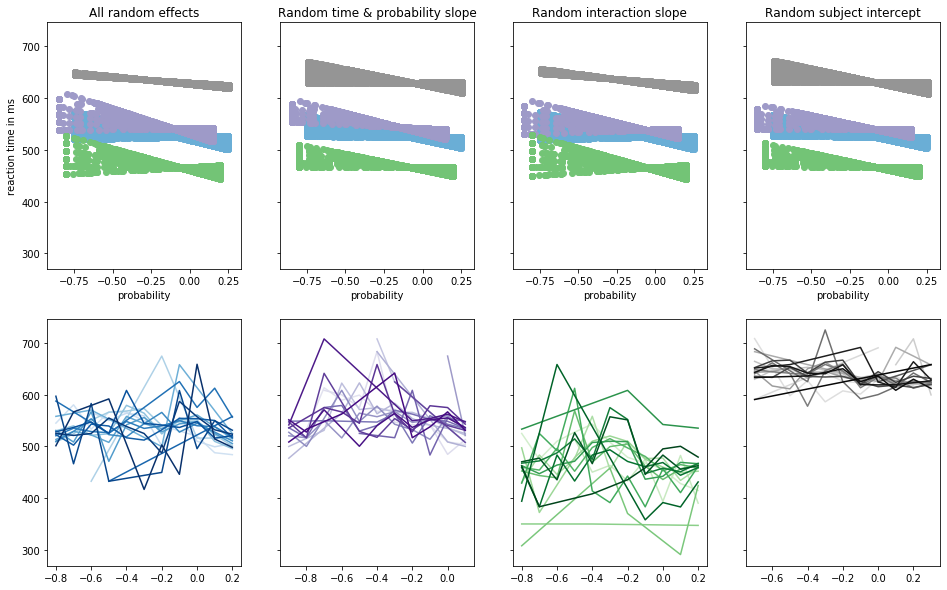

In [27]:
fig_compare_dfs, axs7 = plt.subplots(2,4, figsize = (16,10), sharey = True)

col = [plt.cm.Blues(0.5), plt.cm.Purples(0.5), plt.cm.Greens(0.5), plt.cm.Greys(0.5)]

for pid, p in enumerate(np.unique(df.subject)):
    pdat = df[df.subject == p]
    p_step = np.round(pdat.pin_t, 1)
    
    rt_full = mmod_full.fixef['(Intercept)'][pid] + pdat.time.values*mmod_full.fixef['time'][pid] + pdat.pin_t.values*mmod_full.fixef['pin_t'][pid]+pdat.pin_t.values*pdat.time.values*mmod_full.fixef['pin_t:time'][pid]    
    rt_mains = mmod_full_twoic.fixef['(Intercept)'][pid] + pdat.time.values*mmod_full_twoic.fixef['time'][pid] + pdat.pin_t.values*mmod_full_twoic.fixef['pin_t'][pid]+pdat.pin_t.values*pdat.time.values*mmod_full_twoic.fixef['pin_t:time'][pid]
    rt_ia = mmod_full_ia.fixef['(Intercept)'][pid] + pdat.time.values*mmod_full_ia.fixef['time'][pid] + pdat.pin_t.values*mmod_full_ia.fixef['pin_t'][pid]+pdat.pin_t.values*pdat.time.values*mmod_full_ia.fixef['pin_t:time'][pid]
    rt_ic = mmod_full_ic.fixef['(Intercept)'][pid] + pdat.time.values*mmod_full_ic.fixef['time'][pid] + pdat.pin_t.values*mmod_full_ic.fixef['pin_t'][pid]+pdat.pin_t.values*pdat.time.values*mmod_full_ic.fixef['pin_t:time'][pid]
    
    p_means = [[np.mean(pdat[p_step == pb].rea_time), pb] for pb in np.unique(p_step)]
    p_means = np.array(p_means).T
        
    axs7[0,0].scatter(pdat.pin_t, rt_full, color = col[pid])
    axs7[0,1].scatter(pdat.pin_t, rt_mains, color = col[pid])
    axs7[0,2].scatter(pdat.pin_t, rt_ia, color = col[pid])
    axs7[0,3].scatter(pdat.pin_t, rt_ic, color = col[pid])


col = [plt.cm.Blues, plt.cm.Purples, plt.cm.Greens, plt.cm.Greys]    
for pid, p in enumerate(np.unique(df.subject)):
    pdat = df[df.subject == p].copy()
    pdat['p_step'] = np.round(pdat.pin_t, 1)
    cmap = col[pid](np.linspace(0.2,1, len(np.unique(pdat.time))))
    
    for t,c in zip(np.unique(pdat.time),cmap):
        tdat = pdat[pdat.time == t]
        
        p_means = [[np.mean(tdat[tdat.p_step == pb].rea_time), pb] for pb in np.unique(tdat.p_step)]
        p_means = np.array(p_means).T
        
        axs7[1,pid].plot(p_means[1], p_means[0], color = c )

axs7[0,0].set_title('All random effects')
axs7[0,0].set_ylabel('reaction time in ms')
axs7[0,0].set_xlabel('probability')
axs7[0,1].set_title('Random time & probability slope')
axs7[0,1].set_xlabel('probability')
axs7[0,2].set_title('Random interaction slope')
axs7[0,2].set_xlabel('probability')
axs7[0,3].set_title('Random subject intercept')
axs7[0,3].set_xlabel('probability');

### Verbal summary

It makes a huge difference which random slopes I allow in the model. Not only in terms of how the data is fitted, but also in terms of which predictor variables are labeled as significant.

So the 
# BIG QUESTION
is: how do I know which random effects I should include?